In [37]:
# imports

# data and graphics
import h5py    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# motion correction: https://image-registration.readthedocs.io/en/latest/image_registration.html
from image_registration import chi2_shift
from image_registration.fft_tools import shift
import image_registration

# signal processing
import scipy
from scipy import signal
from scipy.signal import butter,sosfiltfilt, general_gaussian, sosfreqz, detrend, coherence, convolve2d
from scipy.ndimage import median_filter
from scipy.stats import pearsonr

# movie
import imageio

# bladder pressure analysis
import adi

# loadmat
from scipy.io import loadmat

In [43]:
# functions
def import_file(scanFN):
    '''
    Import .scan file from fUS
    '''
    
    with h5py.File(scanFN, 'r') as file:
        mat4D = file['Data'][:]  # Read data from '/Data' dataset

    mat3D = np.squeeze(mat4D)

    return mat3D

# register all to baseline image
def motioncorrect(idx):
    ''' This only shift x and y, does not rotate.
    
    https://image-registration.readthedocs.io/en/latest/image_registration.html
    '''
    
    assert np.min(fUS_orig[idx,...])>=0, f"{idx} not recommended to perform square"
    
    ref = np.sqrt(fUS_orig[0,...]) # this compresses the data to reduce fourier transform artefacts arising from high-signal vessels
    img = np.sqrt(fUS_orig[idx,...])

    xoff, yoff, exoff, eyoff = chi2_shift(ref, img, zeromean=True, boundary='nearest')
            
    return shift.shiftnd(img, (-np.round(yoff,2), -np.round(xoff,2)))**2

# filters
def bandpass(data, cutoff, fs=1, order=2):
    ''' Bandpass filter '''
    sos = butter(order, np.array(cutoff), fs=fs, btype='bandpass', output='sos', analog=False)
    y = sosfiltfilt(sos, data, axis=0)
    return y

# spatial filters
def pillbox(x, show=False):
    kernel = np.array([[0,0,1,0,0],[0,1,1,1,0],[1,1,1,1,1],[0,1,1,1,0],[0,0,1,0,0]])/13.
    pillbox = convolve2d(x, kernel, mode='same')
    
    if show==True:
        plt.imshow(kernel, cmap='gist_gray') # radius 2 pillbox
        plt.show()
    
    return pillbox

# utility functions
def minmax(arr):
    return (arr-arr.min())/(arr.max()-arr.min())

def normalize(arr):
    return (arr-arr.mean())/arr.std()

def to2D(m):
    return m.reshape(fUS_orig.shape[0],-1)

def to3D(m):
    return m.reshape(fUS_orig.shape)

cmap=plt.cm.get_cmap("Spectral_r").copy()
cmap.set_bad(alpha=0)

In [57]:
# -- UDS

# .scan files, .mat files
fnames = {8: (r"Rat08\0.1mL-min filling (standard protocol - sagittal)\sub-fUSXX_ses-Session_2022-3-16_rat8_fUSurodynamics_2Dscan_1_fus2D.source.scan", 
           r"Rat08\Rat08_UDS_sagittal_01mL_min_Pressure_Void.mat"),
       9: (r"Rat09\rat09-sagittal (0.1mL-min)\sub-fUSXX_ses-Session_2022-3-22_rat09_2Dscan_1_fus2D.source.scan",
           r"Rat09\Rat09_UDS_sagittal_01mL_min_Pressure_Void.mat"),
       11: (r"Rat11\rat11_sagittal(0.1mL-min)\sub-fUSXX_ses-Session_2022-3-30_rat11_2Dscan_1_fus2D.source.scan",
            r"Rat11\Rat11_UDS_sagittal_01mL_min_Pressure_Void.mat"),
       14: (r"Rat14\Sagittal (0.1mL-min)\sub-fUSXX_ses-Session_2022-10-4_fUS_UDS_Rat14_2Dscan_1_fus2D.source.scan",
            r"Rat14\Rat14_UDS_sagittal_01mL_min_Pressure_Void.mat"),
       15: (r"Rat15\sagittal (0.1mL)\sub-fUSXX_ses-Session_2022-10-5_fUS_UDS_Rat15_2Dscan_4_fus2D.source.scan",
            r"Rat15\Rat15_UDS_sagittal_01mL_min_Pressure_Void.mat"),
       17: (r"Rat17\sagittal 0.1mL\sub-fUSXX_ses-Session_2022-10-7_fUSi_UDS_rat17_2Dscan_1_fus2D.source.scan",
            r"Rat17\Rat17_UDS_sagittal_01mL_min_Pressure_Void.mat"),
       18: (r"Rat18\(REAL) sagittal 0.1mL (repeat - better fUSi images)\sub-fUSXX_ses-Session_2022-10-11_fUSi-UDS_Rat18_2Dscan_3_fus2D.source.scan",
            r"Rat18\Rat18_UDS_sagittal_01mL_min_Pressure_Void.mat"),
       19: (r"Rat19\rat 19 sagittal 0.1ml-min\sub-fUSXX_ses-Session_2022-10-13_fUSi-UDS_rat019_2Dscan_1_fus2D.source.scan",
            r"Rat19\Rat19_UDS_sagittal_01mL_min_Pressure_Void.mat")
      }

select = 11
fUS = import_file(fnames[select][0])
ivp = loadmat(fnames[select][1])['Pressure_UDS'].flatten()

# backup orig
fUS_orig = fUS.copy()

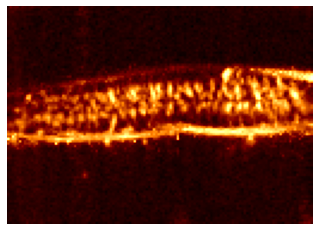

In [58]:
# show fUS image
plt.imshow((fUS_orig[0,...])**.2, cmap='afmhot')
plt.axis('off')
plt.show()

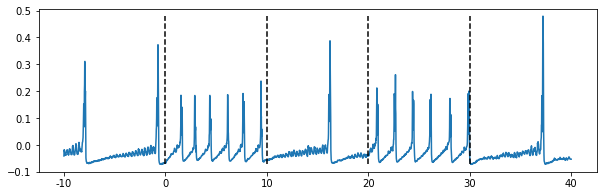

In [59]:
# show ivp curve with timestamps
plt.figure(figsize=(10,3))
plt.plot(ivp)
plt.xticks(np.array([0,10,20,30,40,50,60])*60, [-10,0,10,20,30,40,50])
for j in [10,20,30,40]:
    plt.vlines(j*60,ymin=ivp.min(), ymax=ivp.max(), color='k', linestyle='--')
#plt.xlim(np.array([10,20])*10000*60)
plt.show()

In [60]:
# motion correct
# temporary variables
fUS_ = np.zeros_like(fUS)

for i in range(fUS.shape[0]):
    print('Processing frame', i, 'of', fUS.shape[0], f'({i/fUS.shape[0]*100:.2f}%)', end='\r')
    fUS_[i, ...] = motioncorrect(i)

fUS = fUS_    

# free memory space
del fUS_

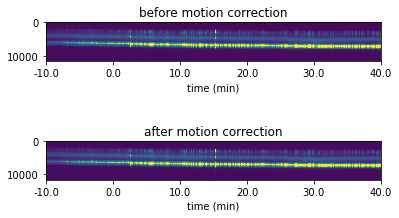

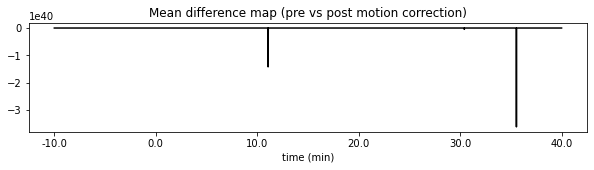

In [135]:
# QC motion stabilization by visualizing which segments are most affected by motion stabilization
fig, ax = plt.subplots(2,1)
ax[0].imshow(to2D(fUS_orig).T, aspect=.03, vmax=100, vmin=0) # before motion correction
locs=np.array([0,10,20,30,40,50])*60
ax[0].set_xticks(locs, labels=np.round(locs/60,0)-10), ax[0].set_xlabel('time (min)')
ax[0].set_title('before motion correction')

ax[1].imshow(to2D(fUS_orig).T, aspect=.03, vmax=100, vmin=0) # after motion correction
ax[1].set_xticks(locs, labels=np.round(locs/60,0)-10), ax[1].set_xlabel('time (min)')
ax[1].set_title('after motion correction')
plt.show()

# mean rms difference
plt.figure(figsize=(10,2))
plt.plot(np.mean(((to2D(fUS)**2-to2D(fUS_orig)**2)**5), axis=1), c='k')
plt.xticks(locs, labels=np.round(locs/60,0)-10), plt.xlabel('time (min)')
plt.title('Mean difference map (pre vs post motion correction)')
plt.show()

In [62]:
# detrend pixel-wise to correct for any baseline drift
fUS_ = detrend(to2D(fUS), axis=0)
fUS = to3D(fUS_)

del fUS_ # free memory

In [63]:
# compute coherence
fs=1
nyq = 0.5 * fs    # Nyquist Frequency
order=2

# bandpass between 30s to 300s period
fUS2D_bandpass=bandpass(to2D(fUS), [1/300, 1/30], fs=fs, order=order)
coherenceIVP = np.zeros(to2D(fUS).shape[1])

for i in range(fUS2D_bandpass.shape[1]):
    print('Processing pixel', i, end='\r')
    f, Cxy = coherence(fUS2D_bandpass[:,i], ivp, fs=1, nperseg=60*5, noverlap=60*4) # calculate based on sliding 5 minute window
    index=np.where((f>=1/300) & (f<=1/30)) # average over 1/30 to 1/300 frequencies
    coherenceIVP[i] = Cxy[index].mean()

Max coherence: 0.539 (pos: 3518) (argmin: 1395), Min coherence: 0.000


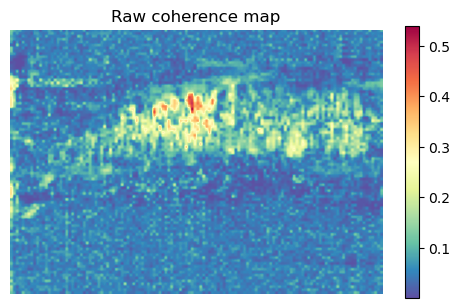

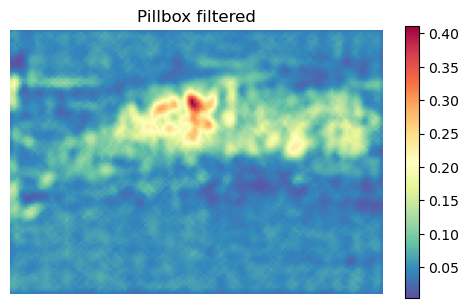

In [137]:
%matplotlib inline
print(f'Max coherence: {np.max(coherenceIVP):.3f} (pos: {np.argmax(coherenceIVP)}) (argmin: {np.argmin(coherenceIVP)}), Min coherence: {np.min(coherenceIVP):.3f}')    

plt.figure(dpi=100)
plt.imshow(coherenceIVP.reshape(fUS.shape[1], fUS.shape[2]), cmap=cmap)
plt.colorbar(shrink=.9)
plt.axis('off')
plt.title('Raw coherence map')
plt.show()

# pillbox filter
pB = pillbox(coherenceIVP.reshape(fUS.shape[1], fUS.shape[2]), show=False)
plt.figure(dpi=100)
plt.imshow(pB, cmap=cmap)
plt.axis('off')
plt.colorbar(shrink=.9)
plt.title('Pillbox filtered')
plt.show()

<IPython.core.display.Javascript object>


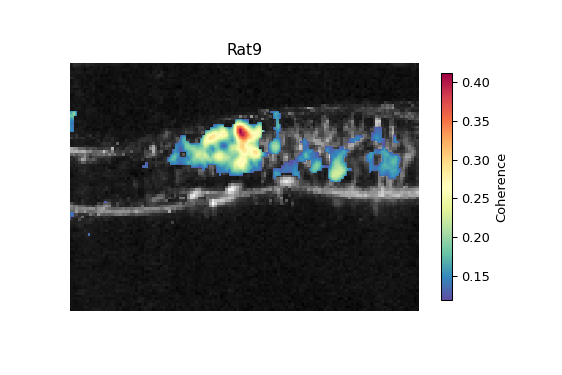

In [132]:
%matplotlib notebook
pB_masked=pB.copy()
pB_masked[pB_masked<np.percentile(pB_masked, 90)]=np.nan # hide bottom 90 percentile

plt.figure(dpi=100)
plt.imshow(fUS_orig[0,...]**.2, cmap='gist_gray', interpolation='none')
plt.imshow(pB_masked, cmap=cmap)
plt.colorbar(label='Coherence', shrink=.8)
plt.axis('off')
plt.title(f'Rat{select}')
plt.show()

In [133]:
#pillbox filter the fUS image
fUS3D_pillbox = np.zeros_like(fUS)

for i in range(to2D(fUS).shape[0]):
    print('Processing time', i, end='\r')
    fUS3D_pillbox[i,...] = pillbox(fUS2D_bandpass.reshape(fUS.shape)[i,...])
    
fUS2D_pillbox = to2D(fUS3D_pillbox)

(3000, 91, 128)
Showing 24 62 3134


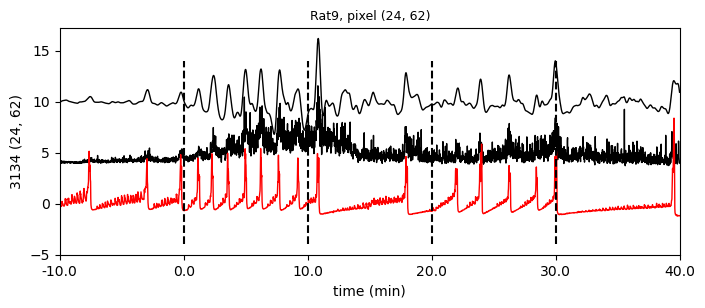

In [134]:
# compare waveforms
%matplotlib inline

print(fUS.shape)

# select voxel
row, column=24,62
pixel=row*128+column

print('Showing', row, column, pixel)

# show waveform
plt.figure(figsize=(8,3), dpi=100)
plt.plot(normalize(fUS2D_pillbox[:,pixel])+10, c='k', lw=1)
plt.plot(normalize(to2D(fUS)[:,pixel])+5, c='k', lw=1)
plt.plot(normalize(ivp), c='r', lw=1)

locs=np.array([0,10,20,30,40,50])*60
plt.xticks(locs, labels=np.round(locs/60,0)-10), plt.xlabel('time (min)')
plt.xlim(np.array([0,50])*60)
plt.ylabel(f'{pixel} ({row}, {column})')
plt.title(f'Rat{select}, pixel {row, column}', fontsize=9)
for j in [10,20,30,40]:
    plt.vlines(j*60,ymin=-4, ymax=14, color='k', linestyle='--')
plt.show()